In [1]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import joblib
import random
import math
from tqdm import tqdm 
from collections import OrderedDict

from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import argrelmax

from sklearn.metrics import mean_squared_error

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim import AdamW
# import pytorch_lightning as pl
# from pytorch_lightning import seed_everything
import lightning as L
from sklearn.metrics import average_precision_score
import timm
from timm.scheduler import CosineLRScheduler

from transformers import get_cosine_schedule_with_warmup

plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes
import polars as pl

from pathlib import Path

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import sys
sys.path.append("/kaggle")
from nn_utils import loss

In [3]:
class CFG:
    # Fundamental config
    NOTDEBUG = True # False -> DEBUG, True -> normally train
    WORKERS = os.cpu_count() // 2
    N_FOLDS = 5
    TRAIN_FOLD = 0
    MAX_LEN = 2**14
    USE_AMP = False
    SEED = 86

    # Model config
    HIDDEN = 256 if NOTDEBUG else 16
    EMB_DIM = 16
    KS = 31 if NOTDEBUG else 7
    N_BLKS = 5 if NOTDEBUG else 2
    DROPOUT = 0.2

    # Optimizer config
    LR = 5e-4
    WD = 1e-2
    WARMUP_PROP = 0.1
    # LR_INIT = 1e-4
    # LR_MIN = 1e-5
    
    # Train config
    EPOCHS = 10
    BS = 32
    MAX_GRAD_NORM = 2.
    GRAD_ACC = 32 // BS

L.seed_everything(CFG.SEED)

INFO: Seed set to 86


86

In [4]:
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

class MakeKFold():
    def __init__(self, n_split=CFG.N_FOLDS, random_state=CFG.SEED, shuffle=True):
        self.n_split = n_split
        self.random_state = random_state
        self.shuffle = shuffle
        self.make_fold()

    def make_fold(self):
        print("making fold")
        skf = StratifiedKFold(n_splits=self.n_split, random_state=self.random_state, shuffle=True)
        metadata = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
        unique_ids = metadata['series_id'].unique()
        meta_cts = pd.DataFrame(unique_ids, columns=['series_id'])
        
        fold_train_ids = []
        fold_valid_ids = []
        
        for i, (train_index, valid_index) in enumerate(skf.split(X=meta_cts['series_id'], y=[1]*len(meta_cts))):
            # if i != TRAIN_FOLD:
            #     continue
            print(f"Fold = {i}")
            train_ids = meta_cts.loc[train_index, 'series_id']
            valid_ids = meta_cts.loc[valid_index, 'series_id']
            print(f"Length of Train = {len(train_ids)}, Length of Valid = {len(valid_ids)}")
            
            fold_train_ids.append(train_ids)
            fold_valid_ids.append(valid_ids)
        self.fold_train_ids = fold_train_ids
        self.fold_valid_ids = fold_valid_ids

    def train_fpaths(self, fold):
        train_fpaths = [f"/kaggle/input/detect-sleep-states-dataprepare/train_csvs/{_id}.csv" for _id in self.fold_train_id[fold]]
        return train_fpaths

    def train_fpaths(self, fold):
        valid_fpaths = [f"/kaggle/input/detect-sleep-states-dataprepare/train_csvs/{_id}.csv" for _id in self.fold_valid_ids[fold]]
        return valid_fpaths


makefold = MakeKFold()
makefold.train_fpaths(0)[:5]

making fold
Fold = 0
Length of Train = 221, Length of Valid = 56
Fold = 1
Length of Train = 221, Length of Valid = 56
Fold = 2
Length of Train = 222, Length of Valid = 55
Fold = 3
Length of Train = 222, Length of Valid = 55
Fold = 4
Length of Train = 222, Length of Valid = 55


['/kaggle/input/detect-sleep-states-dataprepare/train_csvs/05e1944c3818.csv',
 '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/062cae666e2a.csv',
 '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/0cd1e3d0ed95.csv',
 '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/0dee4fda51c3.csv',
 '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/0ec9fc461819.csv']

In [45]:
train_df = pl.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
#train_df
train_df = train_df.with_columns(pl.col('timestamp').str.to_datetime('%Y-%m-%dT%H:%M:%S%z')
                                 .dt.hour()
                                 .alias("datetime_hour"))

<Axes: xlabel='datetime_hour', ylabel='Count'>

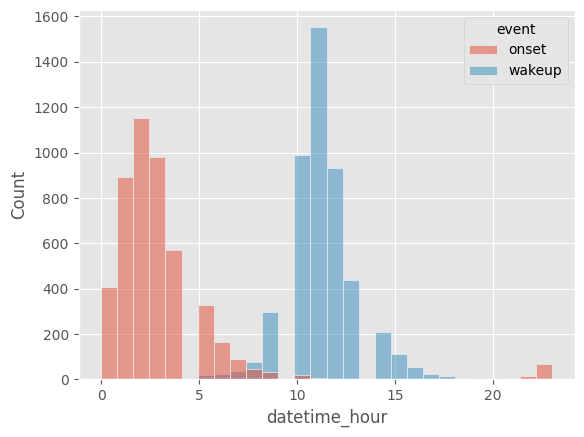

In [57]:
sns.histplot(data=train_df.drop_nulls(subset='datetime_hour'),x='datetime_hour', hue='event')

In [48]:
train_df

series_id,night,event,step,timestamp,datetime_hour
str,i64,str,i64,str,u32
"""038441c925bb""",1,"""onset""",4992,"""2018-08-14T22:…",2
"""038441c925bb""",1,"""wakeup""",10932,"""2018-08-15T06:…",10
"""038441c925bb""",2,"""onset""",20244,"""2018-08-15T19:…",23
"""038441c925bb""",2,"""wakeup""",27492,"""2018-08-16T05:…",9
"""038441c925bb""",3,"""onset""",39996,"""2018-08-16T23:…",3
"""038441c925bb""",3,"""wakeup""",44400,"""2018-08-17T05:…",9
"""038441c925bb""",4,"""onset""",57240,"""2018-08-17T23:…",3
"""038441c925bb""",4,"""wakeup""",62856,"""2018-08-18T06:…",10
"""038441c925bb""",5,"""onset""",null,null,null


In [40]:
train_df['datetime'].dt.hour()

datetime
u32
2
10
23
9
3


In [17]:
pd.to_datetime(viz_series.timestamp,format = )

series_id,night,event,step,timestamp
str,i64,str,i64,str
"""038441c925bb""",1,"""onset""",4992,"""2018-08-14T22:…"
"""038441c925bb""",1,"""wakeup""",10932,"""2018-08-15T06:…"
"""038441c925bb""",2,"""onset""",20244,"""2018-08-15T19:…"
"""038441c925bb""",2,"""wakeup""",27492,"""2018-08-16T05:…"
"""038441c925bb""",3,"""onset""",39996,"""2018-08-16T23:…"
"""038441c925bb""",3,"""wakeup""",44400,"""2018-08-17T05:…"
"""038441c925bb""",4,"""onset""",57240,"""2018-08-17T23:…"
"""038441c925bb""",4,"""wakeup""",62856,"""2018-08-18T06:…"
"""038441c925bb""",5,"""onset""",null,null


In [ ]:
pd.to_datetime(viz_series.timestamp,format = '%Y-%m-%dT%H:%M:%S%z')

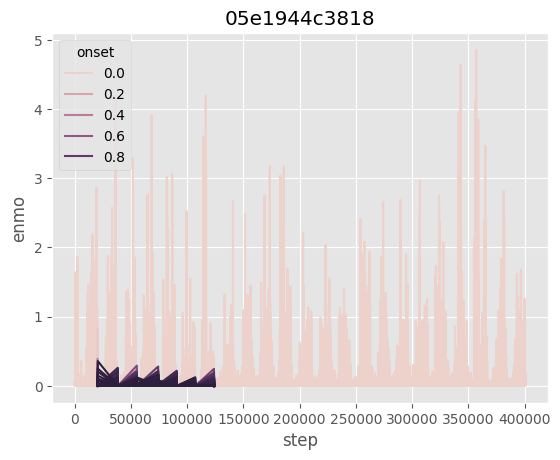

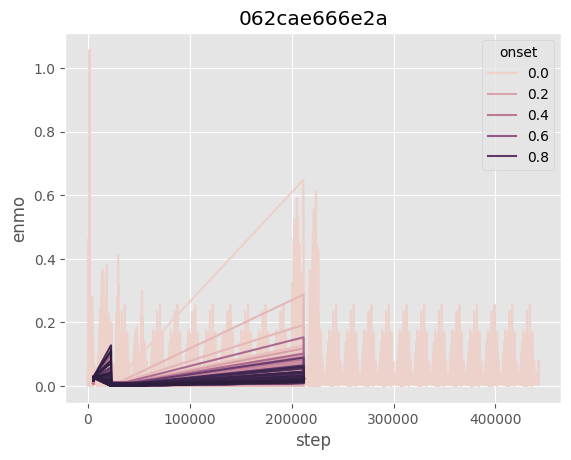

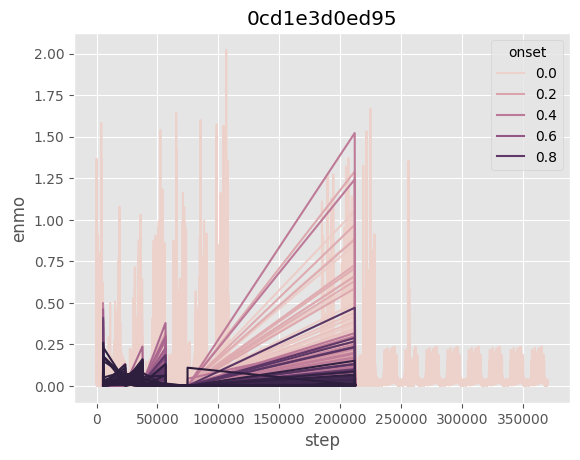

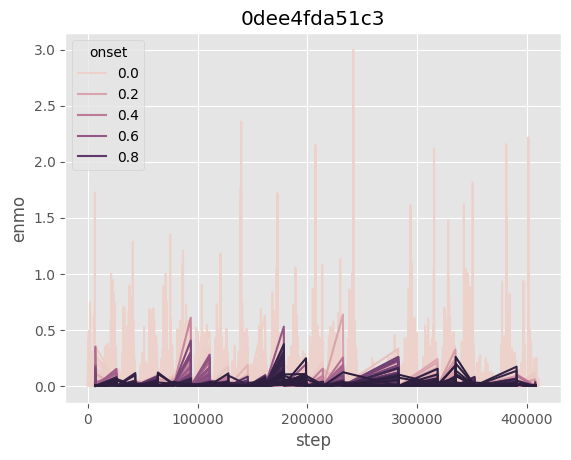

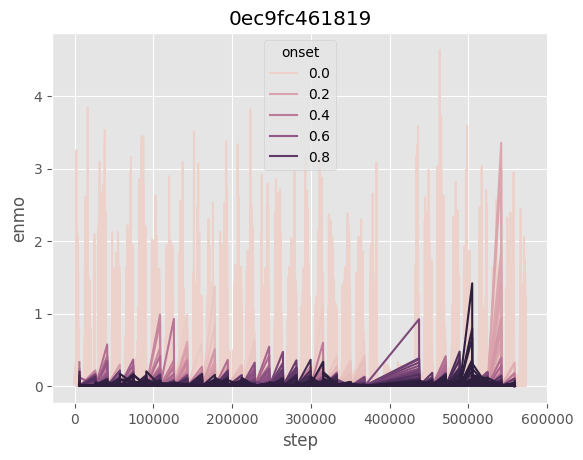

In [13]:
train_df = pl.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
fold = 0
train_fpathes = makefold.train_fpaths(fold)
idx = 0
for idx in range(5):
    filename = os.path.splitext(os.path.basename(train_fpathes[idx]))[0]
    train_df = train_df.filter(
        pl.col('series_id')==filename
    )
    
    df = pl.read_csv(train_fpathes[idx])
    df = df.join(train_df.select(pl.col("step"), pl.col("event")), 
                 on=['step'], how='left')
    df = df.with_columns(
        pl.col("event").fill_null('none')
    )
    p = sns.lineplot(data=df, x="step", y="enmo", hue="onset")
    p.set_title(filename)
    plt.show()

In [ ]:
def seq_block(in_features, out_features, ks=3, drop_rate=0.2, dilation=1):
    padding = ((ks-1)*dilation)//2
    return nn.Sequential(
        nn.Conv1d(in_features, out_features, ks, padding=padding, dilation=dilation),
        nn.BatchNorm1d(out_features),
        nn.LeakyReLU(0.2),
        nn.Dropout(drop_rate)
    )

class SimpleConvNet(nn.Module):
    def __init__(self, in_c=2, out_c=2, hidden=128, emb_dim=8, ks=3, n_blks=3, dropout=0.2):
        super(SimpleConvNet, self).__init__()
        
        self.hr_emb = nn.Embedding(24, emb_dim)
        self.fc1_hr = nn.Linear(emb_dim, emb_dim)
        self.fc2_hr = nn.Linear(emb_dim, emb_dim)
        
        self.fc_in = nn.Linear(in_c+emb_dim, hidden)
        self.blks = nn.Sequential(
            *[seq_block(hidden, hidden, ks, drop_rate=dropout, dilation=2**i) for i in range(n_blks)]
            )
        self.fc_out = nn.Linear(hidden, out_c)
        
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x, h):        
        e = self.hr_emb(h)
        e = self.fc1_hr(e)
        e = self.lrelu(e)
        e = self.fc2_hr(e)

        x = torch.cat([x, e.squeeze(2)], dim=-1)
        x = self.fc_in(x)
        
        x = x.permute(0,2,1)
        
        for b in self.blks:
            x = b(x)

        x = x.permute(0,2,1)
        
        x = self.fc_out(x)
        return x



# PyTorch Lightningモジュールを定義
class LitModule(pl.LightningModule):
    def __init__(self, cfg):
        super(UNetModule, self).__init__()
        #cfg.table_feature_num = len(train_ds.feat_list)
        self.model = SimpleConvNet(in_c=cfg.table_feature_num, out_c=2, 
                                   hidden=cfg.HIDDEN, emb_dim=cfg.EMB_DIM, 
                                   ks=cfg.KS, n_blks=cfg.N_BLKS, dropout=cfg.DROPOUT)
        self.criterion = FocalLoss(alpha=1., gamma=2.)



    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        step_output = self.__share_step(batch, 'train')
        self.log("train/loss", step_output['loss'])
        return step_output
        
    def validation_step(self, batch, batch_idx):
        step_output = self.__share_step(batch, 'val')
        self.log("val/loss", step_output['loss'])
        return step_output

    def predict_step(self, batch, batch_idx):
        images, _ = batch
        logits = self.model(images)
        pred = torch.sigmoid(logits)
        return pred

    def __share_step(self, batch, mode):
        images, masks = batch
        logits = self.model(images)
        loss = self.criterion(logits, masks)
        self.log('train_loss', loss)

        if mode =='train':
            pred = None
        else:
            pred = torch.sigmoid(logits)
        return {'loss':loss, 'pred':pred, 'masks':masks}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)